In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

In [3]:
opt = SGD(learning_rate=1*10**-5)

In [4]:
train_path = os.path.join('chest_xray', 'train')
test_path = os.path.join('chest_xray', 'test')
val_path = os.path.join('chest_xray', 'val')

In [5]:
datagen = ImageDataGenerator()

train_gen = datagen.flow_from_directory(train_path)
test_gen = datagen.flow_from_directory(test_path)
val_gen = datagen.flow_from_directory(val_path)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 141 images belonging to 2 classes.


In [6]:
def visualize_training_results(results):
    """Function that graphs and displays both loss and accuracy for a neural networks history.
    Orginal code from Deeper-Neural-Networks-lab"""
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

The original code for this more complicated ResNet comes from [here](https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba).

In [7]:
def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

In [21]:
def ResNet(image_shape, num_filters = 64):
    input_layer = Input(image_shape)
    X = BatchNormalization()(input_layer)
    X = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(X)
    X = relu_bn(X)
    
    num_blocks_list =[2, 5, 2]
    
    for i in range(len(num_blocks_list)):
        for j in range(num_blocks_list[i]):
            X = residual_block(X, downsample=(j==0 and i !=0), filters=num_filters)
        num_filters *= 2
    
    X = AveragePooling2D(4)(X)
    X = Flatten()(X)
    X = Dense(2, activation='sigmoid')(X)
    
    model = Model(inputs=input_layer, outputs=X, name='ResNet')
    
    model.compile(loss='binary_crossentropy',
                 optimizer=opt,
                  metrics=['accuracy'])
    
    return model

For this residual network I made a lot more layers and added some regularizations but only ended up being able to generate approx. 75,000 trainable params. The results show a good amount of overfitting and I only was able to reach a validation accuracy of 69%.

In [25]:
model_5 = ResNet(image_shape=train_gen.image_shape, num_filters=8)
model_5.summary()


Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization_238 (BatchN (None, 256, 256, 3)  12          input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_254 (Conv2D)             (None, 256, 256, 8)  224         batch_normalization_238[0][0]    
__________________________________________________________________________________________________
re_lu_229 (ReLU)                (None, 256, 256, 8)  0           conv2d_254[0][0]                 
_____________________________________________________________________________________________

In [26]:
results_5 = model_5.fit(train_gen, validation_data=val_gen, epochs=25)

Epoch 1/25
163/163 [==============================] - 2315s 14s/step - loss: 0.6946 - accuracy: 0.5809 - val_loss: 0.7112 - val_accuracy: 0.3901
Epoch 2/25
163/163 [==============================] - 2250s 14s/step - loss: 0.6635 - accuracy: 0.6411 - val_loss: 0.6976 - val_accuracy: 0.5319
Epoch 3/25
163/163 [==============================] - 2181s 13s/step - loss: 0.6367 - accuracy: 0.6900 - val_loss: 0.6982 - val_accuracy: 0.5816
Epoch 4/25
163/163 [==============================] - 2186s 13s/step - loss: 0.6115 - accuracy: 0.7287 - val_loss: 0.6885 - val_accuracy: 0.6099
Epoch 5/25
163/163 [==============================] - 2210s 14s/step - loss: 0.5899 - accuracy: 0.7502 - val_loss: 0.6785 - val_accuracy: 0.6241
Epoch 6/25
163/163 [==============================] - 2203s 14s/step - loss: 0.5696 - accuracy: 0.7676 - val_loss: 0.6701 - val_accuracy: 0.6454
Epoch 7/25
163/163 [==============================] - 2175s 13s/step - loss: 0.5518 - accuracy: 0.7778 - val_loss: 0.6635 - val_ac

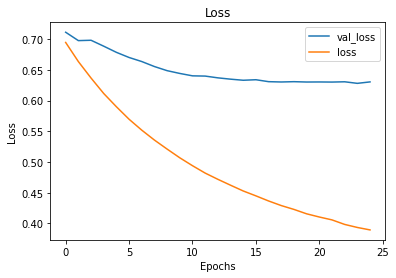

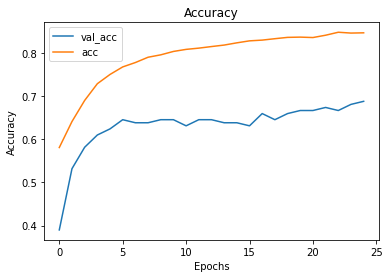

In [27]:
visualize_training_results(results_5)